In [22]:
#Bibliotecas
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
#from scipy.fft import dct as scipy_dct
from scipy.fftpack import dct as scipy_dct
from scipy.fftpack import idct as scipy_idct

In [109]:
def rle_decode(data):
    output = []
    is_repeat = True
    for value in data:
        if is_repeat:
            repeat = value
        else:
            for _ in range(repeat):
                output.append(value)

        is_repeat = not is_repeat

    return output

In [105]:
def rle_encode(data):
    # Lista normal do Python. Veja aula 2.
    encoding = []
    if n data.size == 0:
        # Retorne nada se estiver vazio:
        return encoding
    
    prev = data[0]
    count = 0
    
    for value in data:
        if value != prev:
            # Se o valor atual for diferente dos anteriores,
            # adiciona a contagem e o pixel anterior na nova
            # linha:
            encoding.append(count)
            encoding.append(prev)
                
            count = 1
            prev = value
        else:
            # Se for igual ao valor anterior, incrementa a
            # contagem:
            count += 1
            
    # Adiciona o último valor e sua contagem:
    encoding.append(count)
    encoding.append(prev)
    return encoding

In [108]:
def quantization(img, quantization_table):
    img_quantized = np.zeros(shape = img.shape, dtype=np.int8)
    
    for i in range(8):
        for j in range(8):
            img_quantized[i,j] = round(img[i, j] / quantization_table[i, j]).astype(np.int8)
            
    return img_quantized

In [107]:
def reverse_quantization(img, quantization_table):
    img_quantized = np.zeros(shape = img.shape, dtype=np.int8)
    
    for i in range(8):
        for j in range(8):
            img_quantized[i,j] = round(img[i, j] * quantization_table[i, j]).astype(np.int8)
            
    return img_quantized

#### DCTs multidimensionais

* Por exemplo, podemos usar a DCT-II bidimensional para uma imagem ou matriz;
* É simplesmente a DCT-II unidimensional realizada ao longo das linhas e depois das colunas (ou vice-versa).

$$\begin{align*}
X_{k_1,k_2}&=\alpha_{k_1}\sum_{n_1=0}^{N_1-1}\alpha_{k_2}\left(\sum_{n_2=0}^{N_2-1}x_{n_1,n_2}\cos\left[\frac{\pi}{N_2}\left(n_2+\frac{1}{2}\right)k_2\right]\right)\cos\left[\frac{\pi}{N_1}\left(n_1+\frac{1}{2}\right)k_1\right]\\
&=\alpha_{k_1}\alpha_{k_2}\sum_{n_1=0}^{N_1-1}\sum_{n_2=0}^{N_2-1}x_{n_1,n_2}\cos\left[\frac{\pi}{N_1}\left(n_1+\frac{1}{2}\right)k_1\right]\cos\left[\frac{\pi}{N_2}\left(n_2+\frac{1}{2}\right)k_2\right]\quad k_1,k_2=0,\dots,N-1
\end{align*}$$

$\alpha_{k_1}=\begin{cases}
    \frac{1}{\sqrt{N_1}}, & \text{se}\ k_1=0\\
    \sqrt{\frac{2}{N_1}}, & \text{caso contrário}
\end{cases}$

$\alpha_{k_2}=\begin{cases}
    \frac{1}{\sqrt{N_2}}, & \text{se}\ k_2=0\\
    \sqrt{\frac{2}{N_2}}, & \text{caso contrário}
\end{cases}$

<div>
    <img src="attachment:dct.png" width=512 />
</div>

* A DCT-II tridimensional é a extensão da DCT-II no espaço tridimensional, sendo adequada para vídeos.

$$X_{k_1,k_2,k_3}=\sum_{n_1=0}^{N_1-1}\sum_{n_2=0}^{N_2-1}\sum_{n_3=0}^{N_3-1}x_{n_1,n_2,n_3}\cos\left[\frac{\pi}{N_1}\left(n_1+\frac{1}{2}\right)k_1\right]\cos\left[\frac{\pi}{N_2}\left(n_2+\frac{1}{2}\right)k_2\right]\cos\left[\frac{\pi}{N_3}\left(n_3+\frac{1}{2}\right)k_3\right]\quad k_1,k_2,k_3=0,\dots,N-1$$

![dct3d.png](attachment:dct3d.png)

Feita a transformada, um passo comum é quantizar a imagem (próxima aula) e depois aplicar um ou mais métodos de compressão sem perda (e.g.: RLE e Huffman).

In [3]:
def dct(img):
    N1, N2 = img.shape

    dct = np.zeros(shape = img.shape)
    
    for k1 in range(N1): 
        if k1 == 0:
            a1 = 1 / np.sqrt(N1)
        else:
            a1 = np.sqrt(2 / N1)

        for k2 in range(N2): 
            sum_n1 = 0

            for n1 in range(N1):
                sum_n2 = 0
                
                for n2 in range(N2):
                    x = img[n1, n2]
                    
                    sum_n2 += x * np.cos(np.pi / N2 * (n2 + 0.5) * k2)

                sum_n1 += sum_n2 * np.cos(np.pi / N1 * (n1 + 0.5) * k1)

            if k2 == 0:
                a2 = 1 / np.sqrt(N2)
            else:
                a2 = np.sqrt(2 / N2)

            dct[k1, k2] = sum_n1 * a1 * a2

    return dct

In [116]:
def idct(img):
    N1, N2 = img.shape

    idct = np.zeros(shape=img.shape)
    for n1 in range(N1): # for i in range(l)
        for n2 in range(N2): # for j in range(c)
            sum_k1 = 0

            for k1 in range(N1):
                if k1 == 0:
                    a1 = 1 / np.sqrt(N1)
                else:
                    a1 = np.sqrt(2 / N1)

                sum_k2 = 0
                for k2 in range(N2):
                    if k2 == 0:
                        a2 = 1 / np.sqrt(N2)
                    else:
                        a2 = np.sqrt(2 / N2)

                    x = img[k1, k2]
                    sum_k2 += x * np.cos(np.pi / N2 * (n2 + 0.5) * k2) * a2

                sum_k1 += sum_k2 * np.cos(np.pi / N1 * (n1 + 0.5) * k1) * a1

            idct[n1, n2] = sum_k1

    return idct

In [4]:
def luminosity_grayscale(img):
    (l, c, p) = img.shape
    
    gray = np.zeros(shape = (l, c), dtype = np.uint8)
    
    for i in range(l):
        for j in range(c):
            r = float(img[i, j, 0])
            g = float(img[i, j, 1])
            b = float(img[i, j, 2])
            
            gray[i, j] = 0.2126 * r + 0.7152 * g + 0.0722 * b
            
    return gray

In [5]:
def convert_yCbCr_rgb(img):
    (l, c, p) = img.shape
    
    img_rgb = np.zeros(shape = (l, c, p), dtype = np.uint8)
    
    for i in range(l):
        for j in range(c):
            y = img[i, j, 0]
            cb = img[i, j, 1]
            cr = img[i, j, 2]
            
            r = 1.164 * (y - 16) + 1.596 * (cr - 128)
            g = 1.164 * (y - 16) - 0.392 * (cb - 128) - 0.813 * (cr - 128)
            b = 1.164 * (y - 16) + 2.017 * (cb - 128)
            
            r = np.clip(r, 0, 255)
            g = np.clip(g, 0, 255)
            b = np.clip(b, 0, 255)
            
            img_rgb[i, j, 0] = r
            img_rgb[i, j, 1] = g
            img_rgb[i, j, 2] = b
            
    return img_rgb

In [6]:
def chroma_subsampling(img_y, img_Cb, img_Cr):
    (l, c, p) = img_y.shape
    
    img_subsampling = img_y
    
    for i in range(l):
        for j in range(0, c, 2):
            img_subsampling[i, j, 1] = img_Cb[i, j, 1]
            img_subsampling[i, j + 1, 1] = img_Cb[i, j, 1]
            
            img_subsampling[i, j, 2] = img_Cr[i, j, 2]
            img_subsampling[i, j + 1, 2] = img_Cr[i, j, 2]
    
    return img_subsampling

In [7]:
def convert_rgb_yCbCr(img):
    (l, c, p) = img.shape
    
    img_yCbCr = np.zeros(shape = (l, c, 3), dtype = np.uint8)
    
    img_y = np.zeros(shape = (l, c, 3), dtype = np.uint8)
    img_Cb = np.zeros(shape = (l, c, 3), dtype = np.uint8)
    img_Cr = np.zeros(shape = (l, c, 3), dtype = np.uint8)
    
    for i in range(l):
        for j in range(c):
            r = img[i, j, 0]
            g = img[i, j, 1]
            b = img[i, j, 2]
            
            y = 0.257 * r + 0.505 * g + 0.098 * b + 16  #0.504?
            y = np.clip(y, 16, 235)
            
            cb = -0.148 * r - 0.291 * g + 0.439 * b + 128
            cb = np.clip(cb, 16, 240)
            
            cr = 0.439 * r - 0.368 * g - 0.071 * b + 128
            cr = np.clip(cr, 16, 240)
            
            img_y[i, j] = y
            
            img_Cb[i, j] = cb
            
            img_Cr[i, j] = cr
            
            img_yCbCr[i, j, 0] = y
            img_yCbCr[i, j, 1] = cb
            img_yCbCr[i, j, 2] = cr
            
    return img_yCbCr, img_y, img_Cb, img_Cr

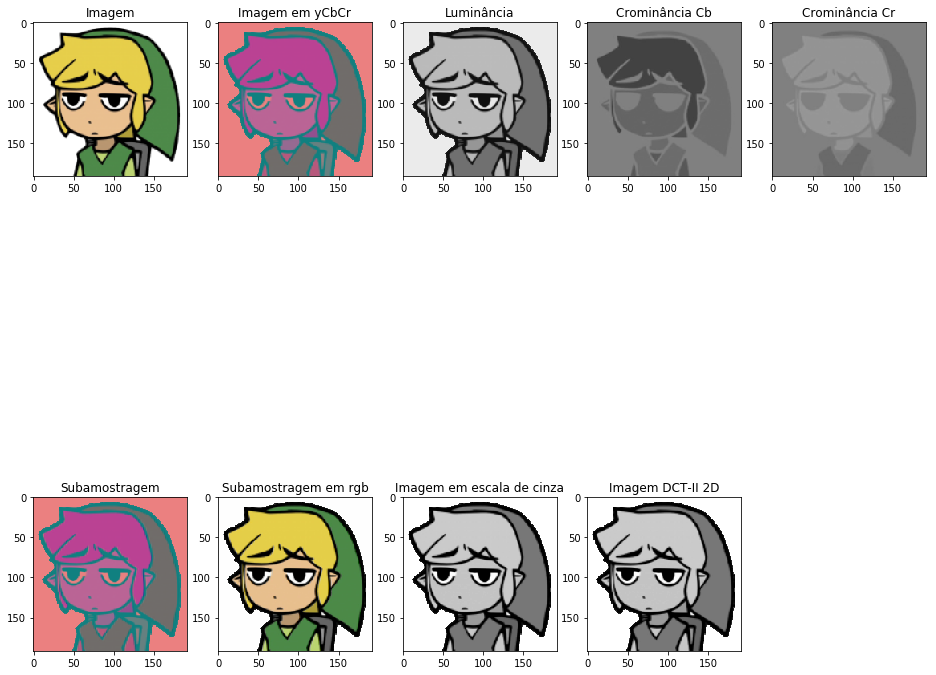

In [94]:
"""
l, c, p = 2, 2, 3
img = np.zeros(shape=(l, c, p), dtype=np.uint8)
img[0, 0] = 255,   0,   0
img[0, 1] =   0, 255,   0
img[1, 0] =   0,   0, 255
img[1, 1] = 255, 255, 255
"""
img = np.array(Image.open('link.jpg'))

plt.figure(figsize = (16, 16))

plt.subplot(2, 5, 1)
plt.title('Imagem')
plt.imshow(img)

(img_yCbCr, img_y, img_Cb, img_Cr) = convert_rgb_yCbCr(img)

plt.subplot(2, 5, 2)
plt.title('Imagem em yCbCr')
plt.imshow(img_yCbCr)

plt.subplot(2, 5, 3)
plt.title('Luminância')
plt.imshow(img_y)

plt.subplot(2, 5, 4)
plt.title('Crominância Cb')
plt.imshow(img_Cb)

plt.subplot(2, 5, 5)
plt.title('Crominância Cr')
plt.imshow(img_Cr)

# Subamostragem de cor
img_subsampling = chroma_subsampling(img_y, img_Cb, img_Cr)

plt.subplot(2, 5, 6)
plt.title('Subamostragem')
plt.imshow(img_subsampling)

# Conversão rbg para yCbCr
img_rgb = convert_yCbCr_rgb(img_subsampling)

plt.subplot(2, 5, 7)
plt.title('Subamostragem em rgb')
plt.imshow(img_rgb)

img_gray = luminosity_grayscale(img_rgb)

plt.subplot(2, 5, 8)
plt.title('Imagem em escala de cinza')
plt.imshow(img_gray, cmap = 'gray')

# Transformada Discreta do Cosseno
img_dct = np.zeros(shape = img_gray.shape)
(l, c) = img_gray.shape

if (l==c and l%8 ==0):

    block_size = 8      #E quando não for multiplo de 8?

    for i in range(0, l, 8):
        for j in range(0, c, 8):
            x = img_gray[i:i + block_size, j:j + block_size]
            img_dct[i:i + block_size, j:j + block_size] = dct(x)
else: 
    
    img_dct = scipy_dct(scipy_dct(img_gray.T, norm='ortho').T, norm='ortho')

plt.subplot(2, 5, 9)
plt.title('Imagem DCT-II 2D')
plt.imshow(img_dct, cmap = 'gray')

quantization_table = np.array(
                      [[16, 11, 10, 16, 24, 40, 51, 61],
                      [12, 12, 14, 19, 26, 58, 60, 55],
                      [14, 13, 16, 24, 40, 57, 69, 56],
                      [14, 17, 22, 29, 51, 87, 80, 62],
                      [18, 22, 37, 56, 68, 109, 103, 77],
                      [24, 35, 55, 64, 81, 104, 113, 92],
                      [49, 64, 78, 87, 103, 121, 120, 101],
                      [72, 92, 95, 98, 112, 100, 103, 99]])



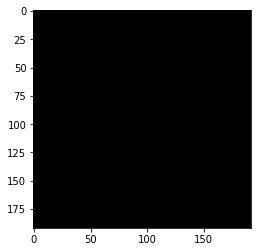

In [99]:
# Quantização
img_quantized = quantization(img_dct, quantization_table)
plt.imshow(img_quantized, cmap = 'gray')

In [106]:
# RLE_ENCODE
img_encoded = rle_encode(img_quantized.flatten())

In [122]:
# Decode
img_decoded = np.reshape(rle_decode(img_encoded), img_gray.shape)
# Desquantização
img_reverse_quantized = reverse_quantization(img_decoded, quantization_table)
# IDCT
l, c = img_reverse_quantized.shape
if (l==c and l%8 ==0):
    block_size = 8      #E quando não for multiplo de 8?

    for i in range(0, l, 8):
        for j in range(0, c, 8):
            x = img_reverse_quantized[i:i + block_size, j:j + block_size]
            img_idct[i:i + block_size, j:j + block_size] = idct(x)
else: 
    print('aqui2')
    img_idct = scipy_idct(scipy_idct(img_reverse_quantized.T, norm='ortho').T, norm='ortho')



192 192
qaui1


In [128]:
print(img_quantized.flatten() == img_decoded.flatten())

[ True  True  True ...  True  True  True]


In [124]:
l, c = img_idct.shape

finally_jpeg_image = np.zeros(shape=(l, c), dtype=np.uint8)
for i in range(l):
    for j in range(c):
        finally_jpeg_image[i,j] = img_idct[i,j] + 128

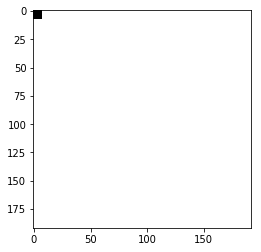

In [126]:
plt.imshow(finally_jpeg_image, cmap='gray')

In [9]:
#https://web.archive.org/web/20180421030430/http://www.equasys.de/colorconversion.html